2023-08-18 23:25:32.022451: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-18 23:25:32.045130: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-18 23:25:32.392724: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-08-18 23:25:32.771833: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.

1/1 [==============================] - 1s 792ms/step
Processed image Otakudesu_SC--12_End_720p_frame_131.jpg
1/1 [==============================] - 0s 10ms/step
Processed image Otakudesu.net_YSNS--12_End_720p_frame_788.jpg
1/1 [==============================] - 0s 14ms/step
Processed image Otakudesu.net_YSNS--12_End_720p_frame_602.jpg
1/1 [==============================] - 0s 14ms/step
Processed image Otakudesu.net_YSNS--12_End_720p_frame_537.jpg
1/1 [==============================] - 0s 10ms/step
Processed image Last Fight - Atlantis The Lost Empire (HD)_frame_789.jpg
1/1 [==============================] - 0s 9ms/step
Processed image Last Fight - Atlantis The Lost Empire (HD)_frame_278.jpg
1/1 [==============================] - 0s 10ms/step
Processed image Last Fight - Atlantis The Lost Empire (HD)_frame_606.jpg
1/1 [==============================] - 0s 10ms/step
Processed image Otakudesu.net_YSNS--12_End_720p_frame_507.jpg
1/1 [==============================] - 0s 10ms/step
Processed

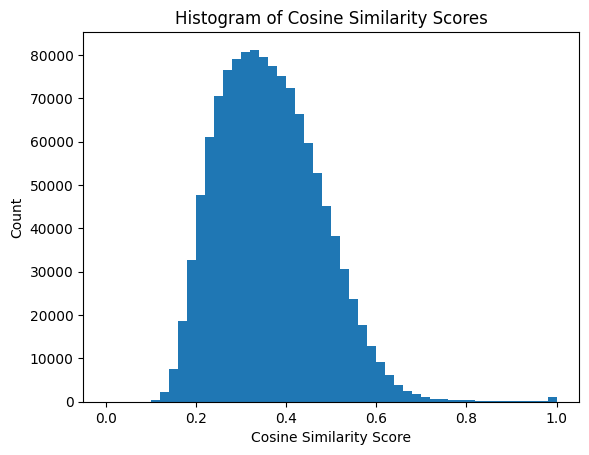

Optimal cosine similarity threshold: 0.5393191412026134
Duplicates will be moved to: ../../faiss/duplicate/trial25/
Found 935 duplicates.


In [1]:
import os
import cv2
import numpy as np
import shutil
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.spatial.distance import pdist, squareform
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
import numpy.matlib

# Load VGG16 model for feature extraction
base_model = VGG16(weights='imagenet')
model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc1').output)

# Function to load and preprocess image
def load_and_process_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (224, 224))
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

# Function to extract features from image
def extract_features(img):
    feature = model.predict(img)
    return np.squeeze(feature)

# Function to move duplicate images to another directory
def move_duplicates(duplicates_dict, target_dir):
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)
    for key, values in duplicates_dict.items():
        for file_path in values:
            try:
                shutil.move(file_path, target_dir)
            except Exception as e:
                print(f"Could not move image {file_path}. Error: {e}")

# New source directory
src_dir = '../../compare-method-for-filtering-out-duplicated-image/image-source1'

# Lists to hold image features and paths
features = []
paths = []

# Iterate over images in source directory
for filename in os.listdir(src_dir):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        try:
            image_path = os.path.join(src_dir, filename)
            img = load_and_process_image(image_path)
            feature = extract_features(img)
            features.append(feature)
            paths.append(image_path)
            print(f"Processed image {filename}")
        except Exception as e:
            print(f"Could not process image {filename}. Error: {e}")

# Convert list of features to array
features = np.array(features)

# Calculate pairwise cosine similarity
cosine_similarities = 1 - squareform(pdist(features, metric='cosine'))

# Flatten the cosine similarities and sort in descending order
sorted_cosine_similarities = np.sort(cosine_similarities.flatten())[::-1]

# Plot a histogram of the cosine similarity scores
plt.hist(sorted_cosine_similarities, bins=50, range=(0.0, 1.0))
plt.title('Histogram of Cosine Similarity Scores')
plt.xlabel('Cosine Similarity Score')
plt.ylabel('Count')
plt.show()

# Define the elbow finding function
def find_elbow(data):
    # normalize data
    data = (data - np.min(data)) / (np.max(data) - np.min(data))
    
    # create coordinates for line
    n_points = len(data)
    all_coords = np.vstack((range(n_points), data)).T
    
    # get vector between first and last point
    line_vec = all_coords[-1] - all_coords[0]
    line_vec_norm = line_vec / np.sqrt(np.sum(line_vec**2))
    
    # calculate vector from first point to all points
    vec_from_first = all_coords - all_coords[0]
    
    # calculate orthogonal vector
    scalar_product = np.sum(vec_from_first * np.matlib.repmat(line_vec_norm, n_points, 1), axis=1)
    vec_from_first_parallel = np.outer(scalar_product, line_vec_norm)
    vec_to_line = vec_from_first - vec_from_first_parallel
    
    # find distance to line
    dist_to_line = np.sqrt(np.sum(vec_to_line ** 2, axis=1))
    
    # find elbow point
    elbow_index = np.argmax(dist_to_line)
    
    return elbow_index

# Find the elbow in the sorted cosine similarities
elbow_index = find_elbow(sorted_cosine_similarities)

# Use the cosine similarity at the elbow point as the threshold
cosine_threshold = sorted_cosine_similarities[elbow_index]

print(f"Optimal cosine similarity threshold: {cosine_threshold}")

# Get indices of pairs with cosine similarity above the threshold
indices = np.where(cosine_similarities > cosine_threshold)

# Get the unique duplicate paths (considering each pair once)
duplicates_dict = defaultdict(list)
handled_images = set()
for i in range(len(indices[0])):
    if indices[0][i] < indices[1][i]:  # consider each pair once
        img1 = paths[indices[0][i]]
        img2 = paths[indices[1][i]]
        if img2 not in handled_images:  # avoid adding an image that has already been identified as a duplicate
            duplicates_dict[img1].append(img2)
            handled_images.add(img2)

# Check for any existing directory with the same name
trial_number = 1
save_dir = f'../../faiss/duplicate/trial{trial_number}/'
while os.path.exists(save_dir):
    trial_number += 1
    save_dir = f'../../faiss/duplicate/trial{trial_number}/'

# Print the directory path and number of duplicates found
print(f"Duplicates will be moved to: {save_dir}")
print(f"Found {sum([len(val) for val in duplicates_dict.values()])} duplicates.")

# Move duplicates to a new directory
move_duplicates(duplicates_dict, save_dir)